In [1]:
# Add cloud to sst glorys
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import sys
import matplotlib.pyplot as plt
import numpy as np
import os
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from glob import glob

#folder_data = "/Odyssey/private/t22picar/data/ssh_L4/"
folder_data = "/Odyssey/public/data_challenge_ssh_ose/data/maps/NeurOST_SSH-SST_allsat-alg/"
#file_obs = "NeurOST_SSH_allsat-al_2019.nc" 
file_obs = "NeurOST_SSH-SST_allsat-al_2019.nc" 

list_of_maps = sorted(glob('/Odyssey/public/data_challenge_ssh_ose/data/maps/NeurOST_SSH_allsat-alg/NeurOST_SSH_allsat-alg_*_20240115.nc'))
#list_of_maps = sorted(glob(f'{folder_data}*.nc'))
#list_of_maps = "/Odyssey/private/t22picar/data/glorys_15m/glorys_15.81m_2019-01-01-2020-01-01.nc"
maps = xr.open_mfdataset(list_of_maps, combine='nested', concat_dim='time')
#maps = xr.open_dataset(folder_data+file_obs)

start_date = "2019-01-01"
end_date = "2019-12-31"
maps = maps.sel(time=slice(start_date, end_date))

In [2]:
maps.coords['longitude'] = (maps.coords['longitude'] + 180) % 360 - 180
#maps.coords['longitude'] = maps.coords['longitude'] - 180
maps = maps.sortby(maps.longitude)

maps = maps.rename({"latitude": "lat"})
maps = maps.rename({"longitude": "lon"})

In [3]:
folder_data_4th = "/Odyssey/private/t22picar/data/glorys_15m/"
file_glorys_4th = "glorys_15.81m_2019-01-01-2020-01-01_4th.nc"

maps_glo_4th = xr.open_dataset(folder_data_4th+file_glorys_4th)


maps_glo_4th = maps_glo_4th.sel(time=slice(start_date, end_date))
#maps = maps.rename({"adt": "zos"})

# Original grid 1/12 (2041,4320) --> 1/4
new_sizes = [size // 3 for size in (2041, 4320)]
print('new sizes: {}'.format(new_sizes))

def regrid_da(regrid_sizes, da: xr.DataArray):

        lat_space = np.linspace(start=maps_glo_4th.lat.min(), stop=maps_glo_4th.lat.max(), num=regrid_sizes[0])
        lon_space = np.linspace(start=maps_glo_4th.lon.min(), stop=maps_glo_4th.lon.max(), num=regrid_sizes[1])

        new_da = da.interp({"lat":lat_space, "lon":lon_space}, method="linear")

        return new_da

new sizes: [680, 1440]


In [4]:
#mean_glorys_ssh = np.nanmean(maps_glo_4th.zos.values)

#With 10y mdt
result_filepath = "/Odyssey/public/glorys/reanalysis/glorys12_2010_2019_mean_zos_4th.nc"
mdt = xr.open_dataset(result_filepath)

maps = maps.rename({"adt": "zos"})
# Interpolation new grid
maps_4th = regrid_da(new_sizes,maps)

maps_4th = maps_4th.transpose('time','lat','lon')

mdt = xr.where(np.isnan(maps_4th.zos[0]),np.nan,mdt)

mean_glorys_ssh = np.nanmean(mdt.mean_zos.values)

(array([4.57945040e-02, 1.24655041e-01, 1.49158995e-01, 1.21542121e-01,
        1.11393785e-01, 1.39008674e-01, 1.68595359e-01, 2.25861612e-01,
        2.37662542e-01, 3.11614235e-01, 6.29920922e-01, 8.35022186e-01,
        8.63976555e-01, 7.07420474e-01, 5.51973408e-01, 1.44226281e-01,
        4.35506733e-02, 7.20911461e-03, 1.22407078e-03, 1.63938051e-04]),
 array([-1.52627589, -1.34177317, -1.15727046, -0.97276775, -0.78826503,
        -0.60376232, -0.41925961, -0.23475689, -0.05025418,  0.13424853,
         0.31875125,  0.50325396,  0.68775667,  0.87225939,  1.0567621 ,
         1.24126481,  1.42576753,  1.61027024,  1.79477295,  1.97927567,
         2.16377838]),
 <BarContainer object of 20 artists>)

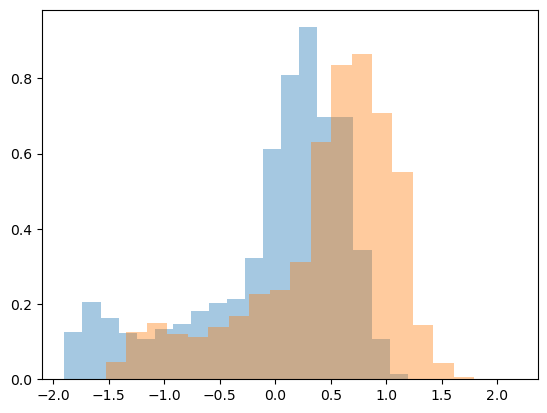

In [5]:
plt.hist(mdt.mean_zos.values.ravel(),20,alpha=0.4,density=True,label='glorys')
plt.hist(maps_4th.zos.values.ravel(),20,alpha=0.4,density=True,label='neurOST')

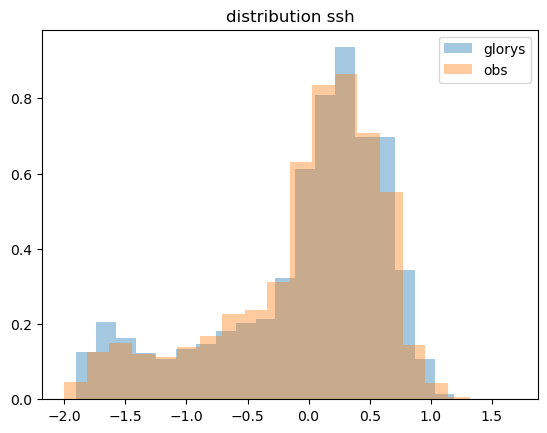

In [6]:
mean_neurost_ssh = np.nanmean(maps_4th.zos.values)
offset = mean_glorys_ssh-mean_neurost_ssh

#plt.hist(maps_glo_4th.zos.values.ravel(),20,alpha=0.4,density=True,label='glorys')

plt.hist(mdt.mean_zos.values.ravel(),20,alpha=0.4,density=True,label='glorys')
plt.hist(maps_4th.zos.values.ravel()+offset,20,alpha=0.4,density=True,label='obs')
plt.title("distribution ssh")
plt.legend()


In [7]:
# Add offset due to different mdt
maps_4th.zos.values = maps_4th.zos.values + offset

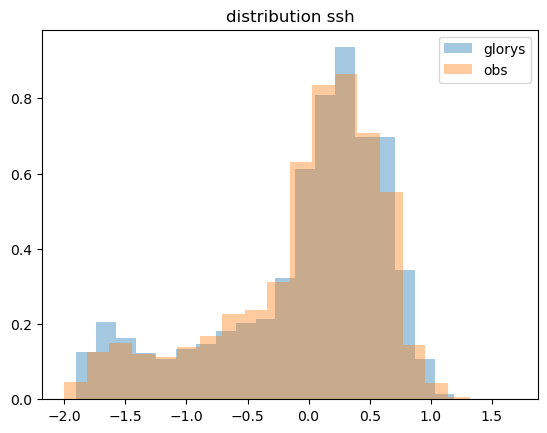

In [8]:

plt.hist(mdt.mean_zos.values.ravel(),20,alpha=0.4,density=True,label='glorys')
plt.hist(maps_4th.zos.values.ravel(),20,alpha=0.4,density=True,label='obs')
plt.title("distribution ssh")
plt.legend()

In [9]:
maps_4th = maps_4th.drop_vars("ugos").drop_vars("vgos").drop_vars("ugosa").drop_vars("vgosa").drop_vars("sla")

In [ ]:
folder_data = "/Odyssey/public/data_challenge_ssh_ose/data/maps/NeurOST_SSH-SST_allsat-alg/"

'/Odyssey/public/data_challenge_ssh_ose/data/maps/NeurOST_SSH-SST_allsat-alg/'

In [42]:
# save data 
file_obs = "NeurOST_SSH-SST_allsat-al_2019_V2.nc" 
save_file=file_obs[:-3]+"_4th"+".nc"
# Sauvegarder le DataArray en fichier NetCDF
maps_4th.to_netcdf(folder_data+save_file)


In [4]:
# Add cloud to sst glorys
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import sys
import matplotlib.pyplot as plt
import numpy as np
import os
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.ticker as mticker

folder_data = "/Odyssey/private/t22picar/data/ssh_L4/"
file_glorys = "SSH_L4_CMEMS_2019_4th.nc" # Actually not glorys 

maps_sst = xr.open_dataset(folder_data+file_glorys)
lat_simu = maps_sst.lat.values
lon_simu = maps_sst.lon.values

folder_data_4th = "/Odyssey/private/t22picar/data/glorys_2020_15m/"
file_glorys_4th = "glorys_15.81m_2020-01-20-2021-04-20_4th.nc"
maps_glo = xr.open_dataset(folder_data_4th+file_glorys_4th)

In [ ]:
maps_glo.lat

<xarray.DataArray 'lat' (lat: 680)> Size: 5kB
array([-80.      , -79.749632, -79.499264, ...,  89.499264,  89.749632,
        90.      ])
Coordinates:
    depth    float32 4B ...
  * lat      (lat) float64 5kB -80.0 -79.75 -79.5 -79.25 ... 89.5 89.75 90.0
Attributes:
    unit_long:      Degrees North
    axis:           Y
    units:          degrees_north
    standard_name:  latitude
    long_name:      Latitude

In [7]:
lon_simu

array([-179.9375    , -179.68741313, -179.43732627, ...,  179.43732627,
        179.68741313,  179.9375    ])